# Stokes discretizations

## Preparation: Meshes

In [ ]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *

shape = Rectangle(1,1).Face()
shape.edges.Max(Y).name="top"
shape.edges.Min(Y).name="bottom"
shape.edges.Max(X).name="right"
shape.edges.Min(X).name="left"


geo = OCCGeometry(shape, dim=2)
mesh1 = Mesh(geo.GenerateMesh(maxh=0.067))
print(f"unstructured mesh with {mesh1.ne} elements and {mesh1.nv} vertices.")
mesh_unstructured = mesh1
Draw (mesh1);

mesh2 = Mesh(geo.GenerateMesh(maxh=0.115))
mesh2.SplitElements_Alfeld()
print(f"Alfeld split mesh with {mesh2.ne} elements and {mesh2.nv} vertices.")
mesh_alfeld = mesh2
Draw (mesh2);


from ngsolve.meshes import MakeStructured2DMesh
mesh3 = MakeStructured2DMesh(nx=16, ny=16, quads=False)
print(f"Structured mesh with {mesh3.ne} elements and {mesh3.nv} vertices.")
mesh_structured = mesh3
Draw (mesh3);

from ngsolve.meshes import MakeStructured2DMesh
mesh4 = MakeStructured2DMesh(nx=8, ny=8, quads=False)
mesh4.Refine()
print(f"Crisscross mesh with {mesh4.ne} elements and {mesh4.nv} vertices.")
mesh_crisscross = mesh4
Draw (mesh4);

## Common discretization things:

In [ ]:
def stokes(U,V):
    (u,p), (v,q) = U, V
    return  InnerProduct(Grad(u), Grad(v))*dx - div(u)*q*dx - div(v)*p*dx

def stokes_reg(U,V):
    (u,p), (v,q) = U, V
    return  InnerProduct(Grad(u), Grad(v))*dx - div(u)*q*dx - div(v)*p*dx - 1e-10*p*q*dx

Function for solving the Stokes problem
 * depending on the FESpace(s) used and 
 * the variational formulation

In [ ]:
def SolveStokes(Wh,stokes_varform = stokes):
    mesh = Wh.mesh
    Wh.FreeDofs()[Wh.components[0].ndof] = False
    a = BilinearForm(stokes_varform(*Wh.TnT())).Assemble()
    f = LinearForm(Wh).Assemble()
    gfu = GridFunction(Wh)
    gfu.components[0].Set(CF((x*(1-x),0)), definedon=mesh.Boundaries("top"))
    f.vec.data -= a.mat * gfu.vec
    print(f"Wh ndofs: {Wh.ndof}, matrix nzes: {a.mat.nze}")
    try:
        gfu.vec.data += a.mat.Inverse(Wh.FreeDofs(), inverse="umfpack") * f.vec
        print("divergence:")
        Draw (div(gfu.components[0]), mesh, "div")
        print("pressure:")
        Draw (gfu.components[1], mesh, "pressure")
        print("velocity:")
        Draw (gfu.components[0], mesh, "velocity")
    except:
        print("Solve failed")
    return gfu

## 9.6.2.2. Unstable Stokes elements

### Example 9.2 (The pair P1-P1).
* $V_h = [V_h^{1}]^d$ : piecewise linear, continuous vector fields
* $Q_h = Q_h^{1,\text{disc}}$ : piecewise linear, continuous scalar fields

In [ ]:
mesh = mesh_unstructured
Vh = VectorH1(mesh, order=1, dirichlet=".*")
Qh = H1(mesh, order=1)
gfu = SolveStokes(Vh*Qh)

Obviously $V_h \subset V \subset [H^1(\Omega)]^d$ and $Q_h \subset H^1(\Omega) \subset Q = L^2(\Omega)$. However, as $\operatorname{div} V_h$ is a space of piecewise constant functions, a pressure function that has mean value zero on every element is in $\ker(B_h^T)$.

(To be inf-sup stable we need $\ker(B_h^T) = \{0\}$.)

Those functions with ``checkerboard'' pattern exist, cf. \cref{fig:checkerboard}, and hence the P1-P1 is not inf-sup stable.


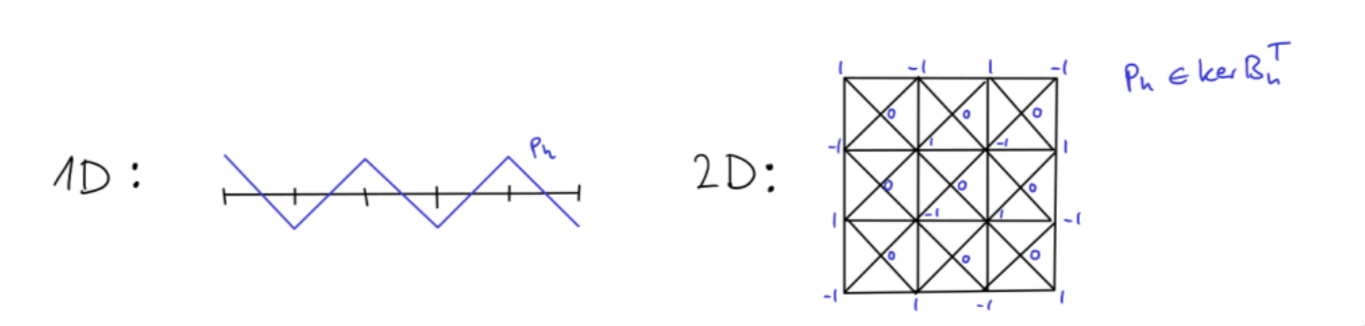

### Remark 9.62 (Brezzi Pitkaranta pressure stabilization).
* Due to its simplicity the P1-P1 pair has been very popular. 
* A stabilization has been introduced to render it useful.
* Brezzi-Pitkaranta pressure stabilizations is a famous stabilization. Add
$\newline\displaystyle 
\sum_{T \in \mathcal{T}_h} \delta_T ({\color{gray} - \Delta u +} \nabla p - f, \nabla q)_T
\newline
$
 for a stabilization parameter $\delta_T \sim h_T^2 > 0$ to the variational formulation. 
 
 * For the true solution the residual vanishes, i.e. this is a \emph{consistent} manipulation. 
 * Further, $(- \Delta u, \nabla q)$ vanishes on the discrete level as $\Delta u_h = 0$ for linear functions.
 * We obtain the stabilized formulation: Find $u_h \in V_h$, $p_h \in Q_h \cap Q$ such that

\begin{align*}
    \nu \int_{\Omega} \nabla u_h : \nabla v_h ~ dx - \int_{\Omega} \operatorname{div}(v_h) p_h ~ dx =& f(v_h) && \forall v_h \in V_h, \\
- \int_{\Omega} \operatorname{div}(u_h) q_h ~  dx - \sum_{T\in\mathcal{T}} \delta_T \int_{T} \nabla p_h \nabla q_h ~ dx = & g(q_h) - \sum_{T\in\mathcal{T}} \delta_T \int_{T} f \nabla q_h ~ dx && \forall q_h \in Q_h.
\end{align*}

 * Here, we assumed that $f \in L^2(\Omega)$.
 * stabilization does not harm global mass conservation

In [ ]:
def stokesBP(U,V):
    (u,p), (v,q) = U, V
    h = specialcf.mesh_size
    return  InnerProduct(Grad(u), Grad(v))*dx - div(u)*q*dx - div(v)*p*dx - 0.1*h**2*grad(p)*grad(q)*dx

In [ ]:
mesh = mesh_unstructured
Vh = VectorH1(mesh, order=1, dirichlet=".*")
Qh = H1(mesh, order=1)
gfu = SolveStokes(Vh*Qh, stokesBP)

### Example 9.3 (The pair P1-P0)

In view of the previous example one may think:
 * decreasing the unknowns in the pressure space may help
 * hence considere $Q_h = Q_h^{0,\text{disc}}$ : piecewise constant, continuous scalar fields


In [ ]:
mesh = mesh_unstructured
Vh = VectorH1(mesh, order=1, dirichlet=".*")
Qh = L2(mesh, order=0)
gfu = SolveStokes(Vh*Qh)

Still unstable! 
Example: 
* Consider a 2D mesh consisting only of four triangles that share a common vertex which is the only interior vertex.
* Assume Dirichlet boundary conditions everywhere. 
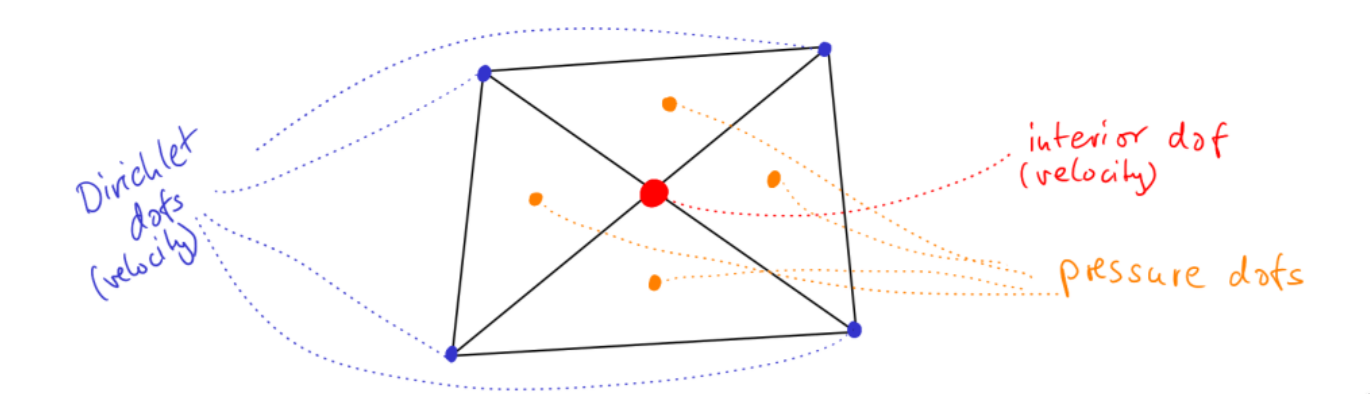
* Then $\dim(V_h) = 2$. But $\dim(Q_h)=4$ (or to be precise $\dim(Q_h)=3$ as $Q_h$ needs to implement the constraint of having mean value zero).

## 9.6.2.3 The MINI / P1+ - P1 element

Despite the two previous counterexamples, there are many different stable Stokes elements.

For instance, the MINI element is obtained by $Q_h = V_h^1$ and $V_h = [V_h^1]^2 \oplus B_{d+1}$ where
  $$
  B_{d+1} := \{ v \in H^1(\Omega) \mid v|_T = c_T \prod_{i=0}^d \lambda_i^T, c_T \in \mathbb{R} \}  
  $$

In [ ]:
mesh = mesh_unstructured
Vh = VectorH1(mesh, order=1, dirichlet=".*")
Vh.SetOrder(TRIG,3)
Vh.Update()
Qh = H1(mesh, order=1)
gfu = SolveStokes(Vh*Qh)

Inf-Sup-stability can be shown by the construction of a Fortin operator $\leadsto$ black board.

--- 
--- 
---


### 9.6.2.4 Other inf-sup stable elements

### Remark 9.63. The Crouzeix-Raviart element 

P1 ${}^{nc}$-P0 ${}^{d}$:

* The Crouzeix-Raviart element uses the non-conforming P1 element for velocity and
* piecewise constant pressure field, 
* non-conforming as $V_h^{1,nc} \not\subset [H^1(\Omega)]^d$
* local mass conservation property $\int_T \operatorname{div} u ~ dx = 0$. 

In [ ]:
mesh = mesh_unstructured
Vh = FESpace("nonconforming",mesh, dirichlet=".*")**2
Qh = L2(mesh, order=0)
gfu = SolveStokes(Vh*Qh)

### Remark 9.64 Taylor-Hood:

One of the most often used Stokes element in finite element theory is the Taylor-Hood pair consisting of:
* continuous velocities of order $k$ and
* continuous pressures of degree $k-1$. 
* It is stable for $k \geq 2$ 
* simple to implement 
* Also stable for higher order approximations

**Technical detail**: needs to have an interior vertex for inf-sup. 

In [ ]:
mesh = mesh_structured
Vh = VectorH1(mesh, order=2, dirichlet=".*")
Qh = H1(mesh, order=1)
gfu = SolveStokes(Vh*Qh)

Higher order:

In [ ]:
mesh = mesh_structured
Vh = VectorH1(mesh, order=4, dirichlet=".*")
Qh = H1(mesh, order=3)
gfu = SolveStokes(Vh*Qh)

### Remark 9.65 Scott-Vogelius elements
* The Scott-Vogelius element is like the Taylor-Hood element but with discontinuous pressures
* There holds $\operatorname{div}(V_h) = Q_h$ so that from $\int \operatorname{div}(u_h) q_h ~ dx = 0~\forall q_h \in Q_h$ there holds with $q_h = \operatorname{div}(u_h)$ that $\operatorname{div} u_h = 0$ pointwise so that $\operatorname{ker}(B_h) \subset \operatorname{ker}(B)$. 
* Methods with $\operatorname{ker}(B_h) \subset \operatorname{ker}(B)$ are often called *exactly divergence-free* methods. 
* However the SV element **is only inf-sup stable for** $k \geq 4$ **in 2D** (**and ** $k \geq 6$  **in 3D**)


In [ ]:
mesh = mesh_structured
Vh = VectorH1(mesh, order=2, dirichlet=".*")
Qh= L2(mesh, order=1)
gfu = SolveStokes(Vh*Qh)

In [ ]:
mesh = mesh_crisscross
Vh = VectorH1(mesh, order=4, dirichlet=".*")
Qh= L2(mesh, order=3)
gfu = SolveStokes(Vh*Qh, stokes_reg)

Stability can be retained on special meshes:

In [ ]:
mesh = mesh_alfeld
Vh = VectorH1(mesh, order=2, dirichlet=".*")
Qh= L2(mesh, order=1)
gfu = SolveStokes(Vh*Qh)

### $P^{2,+} \times P^{1,dc}$ elements:

In [ ]:
Vh = VectorH1(mesh, order=2, dirichlet=".*")
Vh.SetOrder(TRIG,3)
Vh.Update()
Qh = L2(mesh, order=1)
gfu = SolveStokes(Vh*Qh)